In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib.pyplot as plt
import pickle
import copy
%matplotlib inline

In [2]:
#WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-06-20'

In [3]:
#RestorePath = WORKSPACE_PATH+'/raw/'

In [4]:
#cd ~/Documents/ALTIMA/20160624-102423/

In [5]:
'''
csv_file -> ファイル名
mode Round -> 四捨五入
     Roundup -> 切り上げ
     Rounddown -> 切り捨て
'''
def ImportCSV(csv_file,freq,SensorName,mode='Round'):
    # data dictionary 
    RawData={}   

    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 
    # Acc Data  [0.1mG]=>[G]
    # Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    AccX=data.AccX.values*0.0001
    AccY=data.AccY.values*0.0001
    AccZ=data.AccZ.values*0.0001
    GyrX=data.GyrX.values*0.01
    GyrY=data.GyrY.values*0.01
    GyrZ=data.GyrZ.values*0.01

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    # import time by using numpy
    time = data.Time.values #時間の列だけを抽出       

    if mode == 'Roundup':
        func = lambda x: int(x/freq)*freq
    elif mode == 'Rounddown':
        func = lambda x: int(x/freq)*freq
    elif mode == 'Round':
        func = lambda x: int((x+freq/2)/freq)*freq
    #ERROR
    else:
        print 'check mode and inputed word is caused error'
        return -1

    output = map(func,time)
    RawData['Time'] = np.array(output)

    return RawData


In [6]:
def CalcStartTime(array):
    MAX = min(array[0])
    
    for i in range(len(array)):
        if MAX < min(array[i]):
            MAX = min(array[i])
     
    return  MAX

In [7]:
def CalcGoalTime(array):
    MIN = max(array[0])
    
    for i in range(len(array)):
        if MIN > max(array[i]):
            MIN = max(array[i])
     
    return  MIN

In [8]:
"""
    checkData に入れるものは辞書型にする
    freqは計測周期
"""
def NanPating(DicData,freq):
    import time
    start_time = time.time()
    
    # detection for hidden Nan Data
    diffNum =np.array([])
    diffIndex=np.array([])
    checkData = DicData['Time']
    width = len(checkData)
    for i in range(0,width-1):
        if ( checkData[i+1]-checkData[i] )!=freq:
            diffNum=np.append(diffNum, int(checkData[i+1]-checkData[i]) )
            diffIndex=np.append(diffIndex,i)
   
    # insert NAN data to SensorData
    # insert time_data
    def Insert(data,dI,dN,f,mode):
        StartIndex= 0
        tmp =np.array([])
        if mode =='Sensor':
            # insert NAN DATA
            adding = np.nan
            for count,l in enumerate(dI):
                tmp = np.append(tmp, data[StartIndex:int(l)])
                for i in range(0,int(dN[count]/f) ):
                    tmp = np.append(tmp,np.nan)
                StartIndex = int(l)+1
            tmp=np.append(tmp, data[StartIndex:])
        elif mode =='Time':
            # insert 
            for count,l in enumerate(dI):
                tmp = np.append(tmp, data[StartIndex:int(l)])
                for i in range(0,int(dN[count]/f) ):
                    t = int( tmp[-1]+f )
                    tmp = np.append(tmp,t)
                StartIndex = int(l)+1
            tmp=np.append(tmp, data[StartIndex:])
        else:
            print 'mode name error'
        return tmp
    Array ={}
    tmpArrayAccX=Insert(DicData['AccX'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayAccY=Insert(DicData['AccY'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayAccZ=Insert(DicData['AccZ'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayGyrX=Insert(DicData['GyrX'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayGyrY=Insert(DicData['GyrY'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayGyrZ=Insert(DicData['GyrZ'],diffIndex,diffNum,freq,mode='Sensor')
    tmpArrayTime=Insert(DicData['Time'],diffIndex,diffNum,freq,mode='Time')
    Array['AccX'] = tmpArrayAccX
    Array['AccY'] = tmpArrayAccY
    Array['AccZ'] = tmpArrayAccZ
    Array['GyrX'] = tmpArrayGyrX
    Array['GyrY'] = tmpArrayGyrY
    Array['GyrZ'] = tmpArrayGyrZ
    Array['Time'] = tmpArrayTime
    Array['Name'] = DicData['Name']
    #Array=[Time:tmpArrayTime,tmpArrayAccX,tmpArrayAccY,tmpArrayAccZ,tmpArrayGyrX,tmpArrayGyrY,tmpArrayGyrZ]
    elapsed_time = time.time() -start_time
    print ("elapsed_time:{0}".format(elapsed_time)) + "[sec]"
    return Array

In [9]:
"""
    dic　辞書型のリスト
"""
def CalcStartTime(dic):
    MAX = min(dic[0]['Time'])
    
    for i in range(len(dic)):
        if MAX < min(dic[i]['Time']):
            MAX = min(dic[i]['Time'])
     
    return  MAX

In [10]:
"""
    dic　辞書型のリスト
"""
def CalcGoalTime(dic):
    MIN = max(dic[0]['Time'])
    
    for i in range(len(dic)):
        if MIN > max(dic[i]['Time']):
            MIN = max(dic[i]['Time'])
     
    return  MIN

In [11]:
"""
    data　辞書型
    keyTime data['Time']の中の探す値
"""
def CalcSearchIndexFromTime(data, keyTime):
    count = 0
    for i in range(0, len(data['Time'])):
        if keyTime == data['Time'][i]:
            print str(keyTime)+' is much in the index  whose number is '+str(i)
            return i

In [12]:
# name name.pickle = reservedName 
def SaveDicDataFromFileNPZ(name,data):
    np.savez(name, data=data)

In [13]:
"""
    loadName ロードするファイル名
"""
def LoadDicDataFromFileNPZ(loadName):
    arrays = np.load(loadName+'.npz')
    output = arrays['data'][()]
    return output

In [14]:
def MakeCommonSection(inputDataArray):
    # 共通区間のスタート時間、ゴール時間を求める
    startTime = CalcStartTime(inputDataArray)
    goalTime = CalcGoalTime(inputDataArray)

    # 共通区間のスタート時間のインデックス、ゴール時間のインデックスを探索する
    startIndex = np.array([])
    goalIndex = np.array([])
    for obj in inputDataArray:
        print 'start'
        startIndex = np.append(startIndex, CalcSearchIndexFromTime(obj, startTime) ).astype(int)
        print 'goal'
        goalIndex = np.append(goalIndex, CalcSearchIndexFromTime(obj, goalTime) ).astype(int)

    tmp={}
    comDataArray =[]
    key={}

    # センサデータすべて（時刻、加速度、角速度）に対して共通区間のみのデータを抽出
    for number,iDA in enumerate( inputDataArray ):

        tmp['AccX'] = copy.deepcopy( iDA['AccX'][startIndex[number]:goalIndex[number]] )
        tmp['AccY'] = copy.deepcopy( iDA['AccY'][startIndex[number]:goalIndex[number]] )
        tmp['AccZ'] = copy.deepcopy( iDA['AccZ'][startIndex[number]:goalIndex[number]] )
        tmp['GyrX'] = copy.deepcopy( iDA['GyrX'][startIndex[number]:goalIndex[number]] )
        tmp['GyrY'] = copy.deepcopy( iDA['GyrY'][startIndex[number]:goalIndex[number]] )
        tmp['GyrZ'] = copy.deepcopy( iDA['GyrZ'][startIndex[number]:goalIndex[number]] )
        tmp['Time'] = copy.deepcopy( iDA['Time'][startIndex[number]:goalIndex[number]] )
        tmp['Name'] = copy.deepcopy( iDA['Name'] )
        comDataArray.append(copy.deepcopy(tmp) )    
        key[ tmp['Name'] ] = number
        
        # restore dictionary data
        if not ( os.path.exists(RestorePath) ): os.makedirs(RestorePath)
        SaveDicDataFromFileNPZ(RestorePath+tmp['Name'],tmp)
        
    return key,comDataArray

In [15]:
"""
    key dicListの配列番号とdicの名前をつなげる配列
    dicList 辞書型のデータをまとめたリスト
    search 検索するセンサの名前
"""
def GetDicDataFromList(key,dicList,search):
    i = key[search]
    return dicList[i]

In [16]:
LoadDicDataFromFileNPZ("raw/MemSensor1")

{'AccX': array([-0.956 , -0.9609, -0.9589, ..., -0.9714, -0.9731, -0.9768]),
 'AccY': array([ 0.2872,  0.2899,  0.293 , ...,  0.1961,  0.1942,  0.2003]),
 'AccZ': array([-0.0974, -0.0964, -0.1035, ...,  0.0059,  0.0008,  0.0067]),
 'GyrX': array([ 7.98,  8.33,  8.44, ..., -2.07, -1.93, -1.89]),
 'GyrY': array([-7.96, -7.88, -7.93, ..., -0.28, -0.13, -0.11]),
 'GyrZ': array([ 0.18,  0.18,  0.2 , ..., -0.49, -0.35, -0.31]),
 'Name': 'MemSensor1',
 'Time': array([35951381, 35951382, 35951383, ..., 36206120, 36206121, 36206122])}

下のアルゴリズムにデータを渡せれるようなメソッドを作る。

In [17]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


訓練、テストデータを渡すメソッドの流れを考える。
1. 必要なデータの種を渡す
2. すべての種を渡したらコンパイルみたいに種をまとめて、全データの８割を訓練、残りをテストデータにする

**2016-06-25**  
Kerasについて勉強する

Kerasのブログ　[ http://blog.keras.io/building-autoencoders-in-keras.html ]  
model（ネットワーク）の作成


In [18]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

In [19]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [20]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [21]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [22]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [23]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [24]:
autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.3725 - val_loss: 0.2736
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 0.2674 - val_loss: 0.2582
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 0.2478 - val_loss: 0.2347
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 0.2265 - val_loss: 0.2164
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 0.2108 - val_loss: 0.2027
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 0.1986 - val_loss: 0.1919
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 0.1892 - val_loss: 0.1837
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 0.1818 - val_loss: 0.1770
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 0.1758 - val_loss: 0.1716
Epoch 10/50
60000/60000 [==============================] - 0s - loss: 0.1708 - val_loss: 0.1669

In [25]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

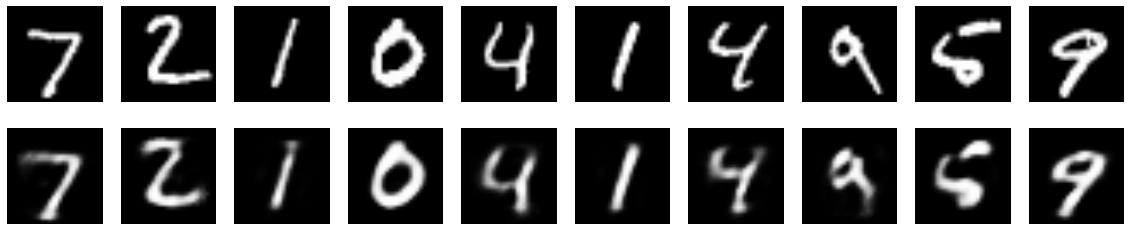

In [26]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

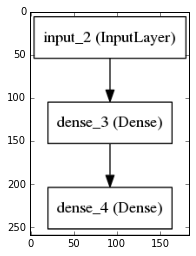

In [27]:
from keras.utils.visualize_util import plot
plot(autoencoder, to_file='model.png')

from PIL import Image
im = Image.open("./model.png")
plt.imshow(im)

In [28]:
x_train.shape

(60000, 784)

実際にAutoEncderをやってみる。

In [33]:
data1=LoadDicDataFromFileNPZ("raw/MemSensor1")
data1['AccX'].shape

(254742,)

In [34]:
data2=LoadDicDataFromFileNPZ("raw/MemSensor2")
data2['AccX'].shape

(254742,)

ここで重要な問題がある。データを共通区間のみにしてPickleにしたところまではできた。  
しかし、windowというフレームに形作ることはできていない。  


In [59]:
def dic2darray(dicData):
    tmp = np.array([])
    
    keys = dicData.keys()
    keys.remove('Name')
    output = dicData[keys[0]]
    for i in range(1, len(keys) ):
        tmp=dicData[keys[i]]
        output = np.vstack( (output,tmp) )
    return output.T

In [84]:
"""
    前提条件として、dicDataのあるインデックスiと次のインデックスi+1との差はサンプリング周期
    もう少し、この関数は変更する
    まずはセンサデータ１つに対してwindowを作るための関数
"""
def PopWindow(dicData,window,overlap=0.5):
    data = dic2darray(dicData)
    i=0
    rows,cols = data.shape
    data = data[0:rows-(rows%window),:cols]
    yield data[i:i+window,:]
    i += int( window*overlap )
    yield data[i:i+window,:]

試しに訓練データはすべてのセンサデータを横並びにする。つまり縦は時系列順

In [90]:
dic1=LoadDicDataFromFileNPZ("raw/MemSensor1")
dic2=LoadDicDataFromFileNPZ("raw/MemSensor2")
dic3=LoadDicDataFromFileNPZ("raw/MemSensor3")
dic4=LoadDicDataFromFileNPZ("raw/MemSensor4")
dic5=LoadDicDataFromFileNPZ("raw/MemSensor5")
dic6=LoadDicDataFromFileNPZ("raw/MemSensor6")
dic7=LoadDicDataFromFileNPZ("raw/MemSensor7")

data1 = dic2darray(dic1)
data2 = dic2darray(dic2)
data3 = dic2darray(dic3)
data4 = dic2darray(dic4)
data5 = dic2darray(dic5)
data6 = dic2darray(dic6)
data7 = dic2darray(dic7)

In [99]:
AllData = np.hstack((data1,data2,data3,data4,data5,data6,data7))

In [106]:
AllData.shape

(254742, 49)

In [104]:
x_train=AllData[range(int( len(AllData)*0.8) ),]
x_test=AllData[range(int( len(AllData)*0.2) ),]

In [98]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

inputShape=49

# this is our input placeholder
input_img = Input(shape=(inputShape,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(inputShape, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

('X_train shape:', (50000, 3, 32, 32))
(50000, 'train samples')
(10000, 'test samples')


In [5]:
X_train[0]

array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ..., 
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ..., 
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ..., 
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)